In [1]:
def  Run_GeoShapesTests(NumEpochs=300):
    %matplotlib notebook
    import keras as keras
    from keras.models import Sequential
    from keras.layers import LSTM, Dense,BatchNormalization,Dropout,Flatten, Conv1D, Conv2D, MaxPool2D
    from keras.losses import binary_crossentropy, categorical_crossentropy
    from keras.metrics import categorical_accuracy
    from keras import regularizers,optimizers
    from keras.regularizers import l2
    import numpy as np
    import scipy.io
    import matplotlib.pyplot as plt
    import gzip
    from keras.layers.core import Lambda
    from scipy.integrate import trapz

    from keras.layers.core import Lambda
    from keras import backend as K    
    
    def mini_batches(InputSample,BatchSize):
        Index = np.array(range(InputSample.shape[0]),dtype=int)
        NumBatches = np.int(InputSample.shape[0]/BatchSize)
        Removed = np.array([],dtype=int)

        BatchInd =[]
        for BatchLoop in range(NumBatches):
            RemainIndex = np.delete(Index,Removed)
            SampleInd = np.random.choice(RemainIndex,size=BatchSize,replace=False)
            Removed = np.append(Removed,SampleInd,axis=0)

            BatchInd.append(SampleInd)
        RemainIndex = np.delete(Index,Removed)
        BatchInd.append(RemainIndex)

        return BatchInd,NumBatches

    def Get_Feats_and_Targets(filename):
        import numpy as np

        def line_to_Feats(line):
            line = line.split(' ')
            Feats = np.asarray(line[0:1024])
            Target = np.zeros([3])
            Target[int(line[1024])] = 1
            return Feats,Target

        f = open(filename, 'r')
        lines = f.readlines()
        Features = []
        Targets = []
        for i in range(len(lines)-1):
            line = lines[i+1]
            Feats,Tgts = line_to_Feats(line)
            Features.append(Feats)
            Targets.append(Tgts)

        return np.asarray(Features,dtype = 'float64'), np.asarray(Targets,dtype = 'int')

    [TrainInputs_Easy,TrainTargets_Easy] = Get_Feats_and_Targets('shapeset1_1cspo_2_3.10000.train.amat')
#     [ValInputs_Easy,ValTargets_Easy] = Get_Feats_and_Targets('shapeset1_1cspo_2_3.5000.valid.amat')

    [TrainInputs,TrainTargets] = Get_Feats_and_Targets('shapeset2_1cspo_2_3.10000.train.amat')
    [ValInputs,ValTargets] = Get_Feats_and_Targets('shapeset2_1cspo_2_3.5000.valid.amat')
    
    FullTrainInputs = np.append(TrainInputs,TrainInputs_Easy,axis=0)
    FullTrainTargets = np.append(TrainTargets,TrainTargets_Easy,axis=0)
    
    Conv = 0
    if Conv == 1:
        TrainInputs_Easy = np.reshape(TrainInputs_Easy,[TrainInputs_Easy.shape[0],1,32,32]).transpose(0,2,3,1)
        TrainInputs = np.reshape(TrainInputs,[TrainInputs.shape[0],1,32,32]).transpose(0,2,3,1)
        ValInputs = np.reshape(ValInputs,[ValInputs.shape[0],1,32,32]).transpose(0,2,3,1)
        FullTrainInputs = np.reshape(FullTrainInputs,[FullTrainInputs.shape[0],1,32,32]).transpose(0,2,3,1)
    
    print(FullTrainInputs.shape)

    data_dim = TrainInputs.shape[1]
    if Conv == 1:
        data_dim2 = TrainInputs.shape[2]
        NumChannels = 1
    NumSamples = TrainInputs.shape[0]
    NumSamplesFull = FullTrainInputs.shape[0]
    NumSamplesEasy = TrainInputs_Easy.shape[0]
    Num_Targets = TrainTargets.shape[-1]

    index = np.linspace(0,NumSamples,NumSamples,endpoint=False,dtype=int)

    reg_coeff = 0
    
    def Gen_Conv_Model(reg_coeff):
        model = Sequential()
        model.add(Conv2D(100,(3,3),activation='relu',input_shape =(data_dim,data_dim2,NumChannels),data_format="channels_last"))
        model.add(MaxPool2D())
        model.add(BatchNormalization())
        model.add(Conv2D(100,(3,3),activation='relu',data_format="channels_last"))
        model.add(MaxPool2D())
        model.add(BatchNormalization())
        model.add(Flatten())
        model.add(Dense(100,activation='relu',kernel_regularizer=l2(reg_coeff)))
        model.add(Dense(100,activation='relu',kernel_regularizer=l2(reg_coeff)))
        model.add(Dense(Num_Targets,activation = 'softmax',kernel_regularizer=l2(reg_coeff),input_shape =(data_dim,)))
        optim = optimizers.adam(lr=0.00001)
        model.compile(loss='categorical_crossentropy',optimizer=optim,metrics=['categorical_accuracy'])

        return model

    def Gen_Model(reg_coeff):
        model = Sequential()
        model.add(Dense(300,activation='tanh',input_shape =(data_dim,),kernel_regularizer=l2(reg_coeff)))
        model.add(Dense(300,activation='tanh',input_shape =(data_dim,),kernel_regularizer=l2(reg_coeff)))
        model.add(Dense(300,activation='tanh',input_shape =(data_dim,),kernel_regularizer=l2(reg_coeff)))
        model.add(Dense(Num_Targets,activation = 'softmax',kernel_regularizer=l2(reg_coeff),input_shape =(data_dim,)))
        optim = optimizers.adam(lr=0.0001)
        model.compile(loss='categorical_crossentropy',optimizer=optim,metrics=['categorical_accuracy'])

        return model
    if Conv == 1:
        UniHard_model = Gen_Conv_Model(reg_coeff) 
        UniEasy_model = Gen_Conv_Model(reg_coeff)
        Cur_model = Gen_Conv_Model(reg_coeff)
        Uni_model = Gen_Conv_Model(reg_coeff)
        Uni_model_full = Gen_Conv_Model(reg_coeff)
    else:
        UniHard_model = Gen_Model(reg_coeff) 
        UniEasy_model = Gen_Model(reg_coeff)
        Cur_model = Gen_Model(reg_coeff)
        Uni_model = Gen_Model(reg_coeff)
        Uni_model_full = Gen_Model(reg_coeff)
    
    UniHard_model.set_weights(Uni_model.get_weights())
    UniEasy_model.set_weights(Uni_model.get_weights())
    Cur_model.set_weights(Uni_model.get_weights())
    Uni_model_full.set_weights(Uni_model.get_weights())
    
    def acquisition_function_BALD(model,samples,Num_Targets,temperature=1,Target_Ratio = 5):
        nb_MC_samples = 100
        MC_output = K.function([model.layers[0].input, K.learning_phase()], [model.layers[-1].output])
        MC_samples = np.zeros([nb_MC_samples,samples.shape[0],Num_Targets])
        learning_phase = True 
        for i in range(nb_MC_samples):
            MC_samples[i,:,:] = np.array([MC_output([samples, learning_phase])[0]])

        expected_entropy = - np.mean(np.sum(MC_samples * np.log(MC_samples + 1e-10), axis=-1), axis=0)  # [batch size]
        expected_p = np.mean(MC_samples, axis=0)
        entropy_expected_p = - np.sum(expected_p * np.log(expected_p + 1e-10), axis=-1)  # [batch size]
        BALD_acq = entropy_expected_p - expected_entropy

        Exp_BALD = np.exp(BALD_acq/temperature)
        Sampling_Prob = Exp_BALD/np.sum(Exp_BALD).astype(float)

        Max_Prob_Ratio = Sampling_Prob.max()/Sampling_Prob.min()
        Target_Ratio = Target_Ratio
        if Max_Prob_Ratio < Target_Ratio:
            while Max_Prob_Ratio <Target_Ratio:
                temperature = temperature*0.99
                Exp_BALD = np.exp(BALD_acq/temperature)
                StoreSampling_Prob = Sampling_Prob.copy()
                Sampling_Prob = Exp_BALD/np.sum(Exp_BALD).astype(float)
                Max_Prob_Ratio = Sampling_Prob.max()/Sampling_Prob.min()
                if np.isnan(Max_Prob_Ratio):
                    Sampling_Prob = StoreSampling_Prob.copy()
        else:
            while Max_Prob_Ratio > Target_Ratio:
                temperature = temperature*1.01
                Exp_BALD = np.exp(BALD_acq/temperature)
                StoreSampling_Prob = Sampling_Prob.copy()
                Sampling_Prob = Exp_BALD/np.sum(Exp_BALD).astype(float)
                Max_Prob_Ratio = Sampling_Prob.max()/Sampling_Prob.min()
                if np.isnan(Max_Prob_Ratio):
                    Sampling_Prob = StoreSampling_Prob.copy()
        return Sampling_Prob

    def acquisition_function_dist_to_threshold(model,samples,Num_Targets,temperature=1,Target_Ratio=5):
        Output = model.predict(samples)
        Output -= 1/float(Num_Targets)
        Dist_to_Threshold = np.sum(np.abs(Output),1)
        Exp_Dist_to_Threshold = np.exp(Dist_to_Threshold/temperature)
        Sampling_Prob = Exp_Dist_to_Threshold/np.sum(Exp_Dist_to_Threshold).astype(float)
        Max_Prob_Ratio = Sampling_Prob.max()/Sampling_Prob.min()
        Target_Ratio = Target_Ratio
        if Max_Prob_Ratio < Target_Ratio:
            while Max_Prob_Ratio <Target_Ratio:
                temperature = temperature*0.99
                Exp_Dist_to_Threshold = np.exp(Dist_to_Threshold/temperature)
                Sampling_Prob = Exp_Dist_to_Threshold/np.sum(Exp_Dist_to_Threshold).astype(float)
                Max_Prob_Ratio = Sampling_Prob.max()/Sampling_Prob.min()
        else:
            while Max_Prob_Ratio > Target_Ratio:
                temperature = temperature*1.01
                Exp_Dist_to_Threshold = np.exp(Dist_to_Threshold/temperature)
                Sampling_Prob = Exp_Dist_to_Threshold/np.sum(Exp_Dist_to_Threshold).astype(float)
                Max_Prob_Ratio = Sampling_Prob.max()/Sampling_Prob.min()
        return Sampling_Prob
    
    
    def Exp_ModelChange(Model,Inputs,Num_Targets):
        ExpChange = np.zeros(Inputs.shape[0])
        for TargetLoop in range(Num_Targets):
            thisTarget = np.zeros([Inputs.shape[0],Num_Targets])
            thisTarget[:,TargetLoop] = 1
            Model_Output = Model.predict(Inputs)
            ClassProb = Model_Output[:,TargetLoop]
            Loss = np.mean(Model_Output - Model_Output*thisTarget + np.log(1+np.exp(-Model_Output)),1)
            ExpChange += Loss*ClassProb
        return ExpChange

    def acquisition_function_exp_model_change(model,samples,Num_Targets,temperature = 1,Target_Ratio = 5):
        ExpectedChange = Exp_ModelChange(model,samples,Num_Targets)
        ExpChange = np.exp(ExpectedChange/temperature)
        Sampling_Prob = ExpChange/np.sum(ExpChange).astype(float)
        Max_Prob_Ratio = Sampling_Prob.max()/Sampling_Prob.min()
        if Max_Prob_Ratio < Target_Ratio:
            while Max_Prob_Ratio <Target_Ratio:
                temperature = temperature*0.99
                ExpChange = np.exp(ExpectedChange/temperature)
                Sampling_Prob = ExpChange/np.sum(ExpChange).astype(float)
                Max_Prob_Ratio = Sampling_Prob.max()/Sampling_Prob.min()
        else:
            while Max_Prob_Ratio > Target_Ratio:
                temperature = temperature*1.01
                ExpChange = np.exp(ExpectedChange/temperature)
                Sampling_Prob = ExpChange/np.sum(ExpChange).astype(float)
                Max_Prob_Ratio = Sampling_Prob.max()/Sampling_Prob.min()
        return Sampling_Prob

    count = 0 
    Num_Epochs = NumEpochs
    Num_BurnIn = 1
    Switch_Epoch = 128
    Batch_Size = 50
    
    NumTasks = 5
    try:
        SwitchPoint = np.int(Num_Epochs/NumTasks)
    except:
        SwitchPoint = 1
    Smoothing_Constant = 0

    Val_Error = np.zeros([Num_Epochs,5])
    Val_Acc = np.zeros([Num_Epochs,5])

    def Biased_Batch(Inputs,Targets,Batch_Size,Sampling_Probability,Weighting_Flag = 1,NumTasks = 0,CurrentTask=0):
        while True:
            index = np.linspace(0,Inputs.shape[0],Inputs.shape[0],endpoint=False,dtype=int)
            if NumTasks > 1:
                Cutoff = np.percentile(Sampling_Probability,np.max(100-(CurrentTask*(1/np.float(NumTasks))*100),0))
    #             LowerCutoff = np.percentile(Sampling_Probability,np.max(100-(CurrentTask*(1/np.float(NumTasks))*100),0))
    #             UpperCutoff = np.percentile(Sampling_Probability,np.max(100-((CurrentTask-1)*(1/np.float(NumTasks))*100),0))
    #             TaskInd = Sampling_Probability >= LowerCutoff
    #             TaskInd[Sampling_Probability > UpperCutoff]= False
    #             Sampling_Probability[:] = 0
    #             Sampling_Probability[TaskInd] = 1
    #             Sampling_Probability = Sampling_Probability/np.sum(Sampling_Probability,dtype=float)
                TaskInd = Sampling_Probability >= Cutoff
                DropInd = Sampling_Probability <  Cutoff
    #             Sampling_Probability[TaskInd] = 1
                Sampling_Probability[DropInd] = 0
                Sampling_Probability = Sampling_Probability/np.sum(Sampling_Probability,dtype=float)

            Batch = np.random.choice(index,size=Batch_Size,replace=False,p=Sampling_Probability)
            Batch_Inputs = Inputs[Batch,:]
            Batch_Targets = Targets[Batch,:]
            if Weighting_Flag == 1:
                FullWeights = Sampling_Probability**-1
                FullWeights = FullWeights/np.mean(FullWeights)
            elif Weighting_Flag == -1:
                FullWeights = Sampling_Probability/np.mean(Sampling_Probability)
            else:
                FullWeights = np.ones(Inputs.shape[0])
            Weights = FullWeights[Batch]
            yield (Batch_Inputs,Batch_Targets,Weights)
            
    fig = plt.figure(figsize = [4,4])
    ax = fig.add_subplot(111)
    plt.ion()
    fig.show()
    fig.canvas.draw()
    
    fig2 = plt.figure(figsize = [4,4])
    ax2 = fig2.add_subplot(111)
    plt.ion()
    fig2.show()
    fig2.canvas.draw()
    
    fig3 = plt.figure(figsize = [4,4])
    ax3 = fig3.add_subplot(111)
    plt.ion()
    fig3.show()
    fig3.canvas.draw()
    
    fig4 = plt.figure(figsize = [4,4])
    ax4 = fig4.add_subplot(111)
    plt.ion()
    fig4.show()
    fig4.canvas.draw()


    for EpochLoop in  range(Num_Epochs):
        if count < Num_BurnIn:

#             Uni_model.fit_generator(Biased_Batch(TrainInputs,TrainTargets,Batch_Size,1/np.float(NumSamples)*np.ones(NumSamples)),
#                                 steps_per_epoch=np.int(NumSamples/Batch_Size),verbose=0)
            
            Uni_model_full.fit_generator(Biased_Batch(FullTrainInputs,FullTrainTargets,Batch_Size,1/np.float(NumSamplesFull)*np.ones(NumSamplesFull)),
                                steps_per_epoch=np.int(NumSamplesFull/Batch_Size),verbose=1)

            if count < Switch_Epoch:
                Cur_model.fit_generator(Biased_Batch(TrainInputs_Easy,TrainTargets_Easy,Batch_Size,1/np.float(NumSamplesEasy)*np.ones(NumSamplesEasy)),
                                steps_per_epoch=np.int(NumSamplesEasy/Batch_Size),verbose=0)
            else:
                Cur_model.fit_generator(Biased_Batch(FullTrainInputs,FullTrainTargets,Batch_Size,1/np.float(NumSamplesFull)*np.ones(NumSamplesFull)),
                                steps_per_epoch=np.int(NumSamplesFull/Batch_Size),verbose=0)
            
            UniHard_model.set_weights(Uni_model_full.get_weights())
            UniEasy_model.set_weights(Uni_model_full.get_weights())
            
            Error = UniHard_model.test_on_batch(ValInputs,ValTargets)
            Val_Error[count,0] = Error[0]
            Val_Acc[count,0] = Error[1]

            Error = UniEasy_model.test_on_batch(ValInputs,ValTargets)
            Val_Error[count,1] = Error[0]
            Val_Acc[count,1] = Error[1]

            Error = Uni_model.test_on_batch(ValInputs,ValTargets)
            Val_Error[count,2] = Error[0]
            Val_Acc[count,2] = Error[1]

            Error = Cur_model.test_on_batch(ValInputs,ValTargets)
            Val_Error[count,3] = Error[0]
            Val_Acc[count,3] = Error[1]
            
            Error = Uni_model_full.test_on_batch(ValInputs,ValTargets)
            Val_Error[count,4] = Error[0]
            Val_Acc[count,4] = Error[1]


        else:
            
            UniHard_Sampling_Probability = acquisition_function_dist_to_threshold(UniHard_model,FullTrainInputs,Num_Targets,1,10)
            UniEasy_Sampling_Probability = 1/acquisition_function_dist_to_threshold(UniEasy_model,FullTrainInputs,Num_Targets,1,10)
            UniEasy_Sampling_Probability /= UniEasy_Sampling_Probability.sum().astype(float)
            
            MaxProbInd = UniHard_Sampling_Probability.argmax()
            MinProbInd = UniHard_Sampling_Probability.argmin()
            
            if Conv == 1:
                ax3.clear()
                ax3.imshow(FullTrainInputs[MaxProbInd,:,:,:].reshape([32,32]))
                fig3.canvas.draw()
                ax4.clear()
                ax4.imshow(FullTrainInputs[MinProbInd,:,:].reshape([32,32]))
                fig4.canvas.draw()
            else:
                ax3.clear()
                ax3.imshow(FullTrainInputs[MaxProbInd,:].reshape([32,32]))
                fig3.canvas.draw()
                ax4.clear()
                ax4.imshow(FullTrainInputs[MinProbInd,:].reshape([32,32]))
                fig4.canvas.draw()

#             ax3.clear()
#             ax3.imshow(np.transpose(np.reshape(FullTrainInputs[MaxProbInd,:],[32,32])))
#             fig3.canvas.draw()

#             ax4.clear()
#             ax4.imshow(np.transpose(np.reshape(FullTrainInputs[MinProbInd,:],[32,32])))
#             fig4.canvas.draw()
    
            
            print(UniEasy_Sampling_Probability.max()/UniEasy_Sampling_Probability.min())

            UniHard_model.fit_generator(Biased_Batch(FullTrainInputs,FullTrainTargets,Batch_Size,UniHard_Sampling_Probability,0,NumTasks,np.int(count/SwitchPoint)+1),
                                     steps_per_epoch=np.int(NumSamplesFull/Batch_Size),verbose=1)

            UniEasy_model.fit_generator(Biased_Batch(FullTrainInputs,FullTrainTargets,Batch_Size,UniEasy_Sampling_Probability,0,NumTasks,np.int(count/SwitchPoint)+1),
                                     steps_per_epoch=np.int(NumSamplesFull/Batch_Size),verbose=1)

#             Uni_model.fit_generator(Biased_Batch(TrainInputs,TrainTargets,Batch_Size,1/(NumSamples*np.ones(NumSamples))),
#                                     steps_per_epoch=np.int(NumSamples/Batch_Size),verbose=0)
            
            Uni_model_full.fit_generator(Biased_Batch(FullTrainInputs,FullTrainTargets,Batch_Size,1/(NumSamplesFull*np.ones(NumSamplesFull))),
                                    steps_per_epoch=np.int(NumSamplesFull/Batch_Size),verbose=1)

            if count < Switch_Epoch:
                Cur_model.fit_generator(Biased_Batch(TrainInputs_Easy,TrainTargets_Easy,Batch_Size,1/np.float(NumSamplesEasy)*np.ones(NumSamplesEasy)),
                                steps_per_epoch=np.int(NumSamplesEasy/Batch_Size),verbose=0)
            else:
                Cur_model.fit_generator(Biased_Batch(FullTrainInputs,FullTrainTargets,Batch_Size,1/np.float(NumSamplesFull)*np.ones(NumSamplesFull)),
                                steps_per_epoch=np.int(NumSamplesFull/Batch_Size),verbose=0)
            
            Error = UniHard_model.test_on_batch(ValInputs,ValTargets)
            Val_Error[count,0] = Error[0]
            Val_Acc[count,0] = Error[1]

            Error = UniEasy_model.test_on_batch(ValInputs,ValTargets)
            Val_Error[count,1] = Error[0]
            Val_Acc[count,1] = Error[1]

            Error = Uni_model.test_on_batch(ValInputs,ValTargets)
            Val_Error[count,2] = Error[0]
            Val_Acc[count,2] = Error[1]

            Error = Cur_model.test_on_batch(ValInputs,ValTargets)
            Val_Error[count,3] = Error[0]
            Val_Acc[count,3] = Error[1]
            
            Error = Uni_model_full.test_on_batch(ValInputs,ValTargets)
            Val_Error[count,4] = Error[0]
            Val_Acc[count,4] = Error[1]
            
        print(count)

        count += 1
        ax.clear()
        ax.plot(Val_Error[0:count,0],label='IS-Hard')
        ax.plot(Val_Error[0:count,1],label='IS-Easy')
        ax.plot(Val_Error[0:count,2],label='Uniform')
        ax.plot(Val_Error[0:count,4],label='Uniform - Full')
        ax.plot(Val_Error[0:count,3],label='Curriculum 128')
        ax.legend(loc='best')
        fig.canvas.draw()
        
        ax2.clear()
        ax2.plot(Val_Acc[0:count,0],label='IS-Hard')
        ax2.plot(Val_Acc[0:count,1],label='IS-Easy')
        ax2.plot(Val_Acc[0:count,2],label='Uniform')
        ax2.plot(Val_Acc[0:count,4],label='Uniform - Full')
        ax2.plot(Val_Acc[0:count,3],label='Curriculum 128')
        fig2.canvas.draw()


    [TestInputs,TestTargets] = Get_Feats_and_Targets('shapeset2_1cspo_2_3.5000.test.amat')
    
    if Conv == 1:
        TestInputs = np.reshape(TestInputs,[TestInputs.shape[0],1,32,32]).transpose(0,2,3,1)

    TestError = np.zeros([5,2])
    TestError[0,:] = UniHard_model.test_on_batch(TestInputs,TestTargets)
    TestError[1,:] = UniEasy_model.test_on_batch(TestInputs,TestTargets)
    TestError[2,:] = Uni_model.test_on_batch(TestInputs,TestTargets)
    TestError[3,:] = Cur_model.test_on_batch(TestInputs,TestTargets)
    TestError[4,:] = Uni_model_full.test_on_batch(TestInputs,TestTargets)
    
    return Val_Error,Val_Acc,TestError

Test Number:
0


Using TensorFlow backend.


(20000, 1024)


<IPython.core.display.Javascript object>


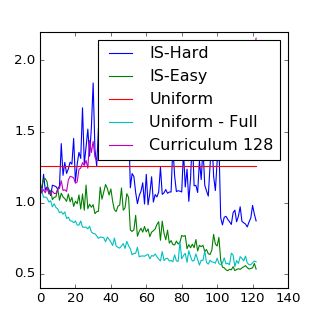

<IPython.core.display.Javascript object>


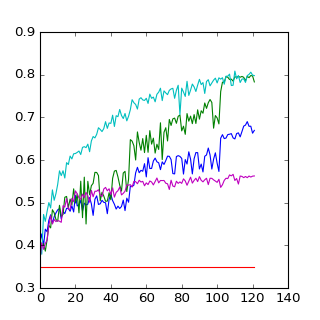

<IPython.core.display.Javascript object>


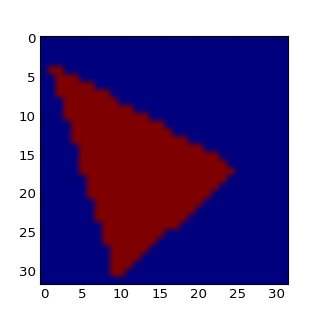

<IPython.core.display.Javascript object>


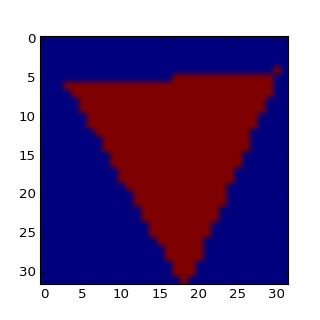

Epoch 1/1
400/400 [==============================] - 3s 7ms/step - loss: 1.0964 - categorical_accuracy: 0.3813
0
10.092102
Epoch 1/1
400/400 [==============================] - 3s 7ms/step - loss: 0.8509 - categorical_accuracy: 0.6192
Epoch 1/1
400/400 [==============================] - 3s 7ms/step - loss: 1.0447 - categorical_accuracy: 0.4614
Epoch 1/1
400/400 [==============================] - 3s 6ms/step - loss: 1.0539 - categorical_accuracy: 0.4313
1
10.214285
Epoch 1/1
400/400 [==============================] - 3s 9ms/step - loss: 0.6883 - categorical_accuracy: 0.7161
Epoch 1/1
400/400 [==============================] - 4s 10ms/step - loss: 0.9968 - categorical_accuracy: 0.4969
Epoch 1/1
400/400 [==============================] - 3s 8ms/step - loss: 1.0240 - categorical_accuracy: 0.4713
2
10.167522
Epoch 1/1
400/400 [==============================] - 3s 7ms/step - loss: 0.7015 - categorical_accuracy: 0.6808
Epoch 1/1
400/400 [==============================] - 3s 7ms/step - loss: 0.

In [ ]:
import numpy as np
import datetime

from IPython.display import clear_output

NumTests = 1000
NumEpochs = 256
Val_Error_Record = np.zeros([NumEpochs,5,NumTests])
Val_Acc_Record = np.zeros([NumEpochs,5,NumTests])
Test_Perf_Record = np.zeros([5,2,NumTests])

for TestLoop in range(NumTests):
    clear_output()
    print('Test Number:')
    print(TestLoop)
    Val_Error_Record[:,:,TestLoop],Val_Acc_Record[:,:,TestLoop],Test_Perf_Record[:,:,TestLoop] = Run_GeoShapesTests(NumEpochs)
    
    DateString = str(datetime.datetime.date(datetime.datetime.now()))
    
    np.save("GeoShapes_Curriculum_FullUniform_TestPerf_Self_Paced",Test_Perf_Record)
    np.save("GeoShapes_Curriculum_FullUniform_ValError_Self_Paced",Val_Error_Record)
    np.save("GeoShapes_Curriculum_FullUniform_ValAcc_Self_Paced",Val_Acc_Record)

In [ ]:
a,b,c = Run_GeoShapesTests(NumEpochs)

In [2]:
%matplotlib notebook
import keras as keras
from keras.models import Sequential
from keras.layers import LSTM, Dense,BatchNormalization,Dropout,Flatten, Conv1D, Conv2D, MaxPool2D
from keras.losses import binary_crossentropy, categorical_crossentropy
from keras.metrics import categorical_accuracy
from keras import regularizers,optimizers
from keras.regularizers import l2
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
import gzip
from keras.layers.core import Lambda
from scipy.integrate import trapz

from keras.layers.core import Lambda
from keras import backend as K    

def mini_batches(InputSample,BatchSize):
    Index = np.array(range(InputSample.shape[0]),dtype=int)
    NumBatches = np.int(InputSample.shape[0]/BatchSize)
    Removed = np.array([],dtype=int)

    BatchInd =[]
    for BatchLoop in range(NumBatches):
        RemainIndex = np.delete(Index,Removed)
        SampleInd = np.random.choice(RemainIndex,size=BatchSize,replace=False)
        Removed = np.append(Removed,SampleInd,axis=0)

        BatchInd.append(SampleInd)
    RemainIndex = np.delete(Index,Removed)
    BatchInd.append(RemainIndex)

    return BatchInd,NumBatches

def Get_Feats_and_Targets(filename):
    import numpy as np

    def line_to_Feats(line):
        line = line.split(' ')
        Feats = np.asarray(line[0:1024])
        Target = np.zeros([3])
        Target[int(line[1024])] = 1
        return Feats,Target

    f = open(filename, 'r')
    lines = f.readlines()
    Features = []
    Targets = []
    for i in range(len(lines)-1):
        line = lines[i+1]
        Feats,Tgts = line_to_Feats(line)
        Features.append(Feats)
        Targets.append(Tgts)

    return np.asarray(Features,dtype = 'float64'), np.asarray(Targets,dtype = 'int')

[TrainInputs_Easy,TrainTargets_Easy] = Get_Feats_and_Targets('shapeset1_1cspo_2_3.10000.train.amat')
#     [ValInputs_Easy,ValTargets_Easy] = Get_Feats_and_Targets('shapeset1_1cspo_2_3.5000.valid.amat')

[TrainInputs,TrainTargets] = Get_Feats_and_Targets('shapeset2_1cspo_2_3.10000.train.amat')
[ValInputs,ValTargets] = Get_Feats_and_Targets('shapeset2_1cspo_2_3.5000.valid.amat')

FullTrainInputs = np.append(TrainInputs,TrainInputs_Easy,axis=0)
FullTrainTargets = np.append(TrainTargets,TrainTargets_Easy,axis=0)

Using TensorFlow backend.


In [9]:
test = FullTrainInputs.var(axis=1)
np.unique(FullTrainInputs)

array([0.  , 0.14, 0.29, 0.43, 0.57, 0.71, 0.86, 1.  ])

<IPython.core.display.Javascript object>


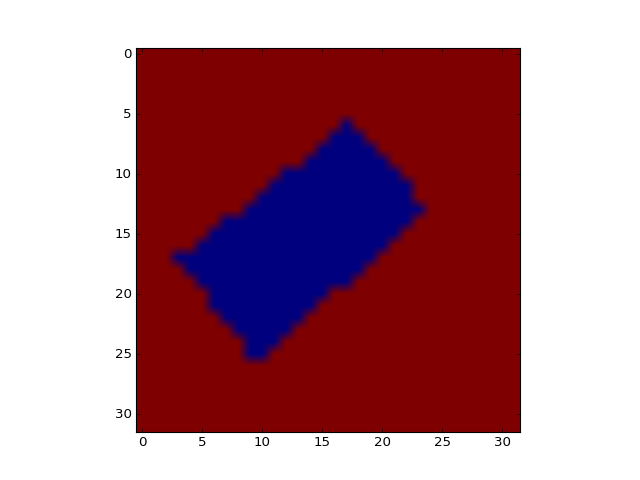

In [11]:
# minvar = test.argmin()
minvar = 0

plt.imshow(FullTrainInputs[minvar,:].reshape([32,32]))

In [17]:
from keras.activations import relu
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.regularizers import l2
data_dim = 10
reg_coeff = 0.01

In [18]:
model = Sequential()
model.add(Dense(100,input_shape =(data_dim,),kernel_regularizer=l2(reg_coeff)))
model.add(Activation(relu))

Using TensorFlow backend.


(20000, 1024)


<IPython.core.display.Javascript object>


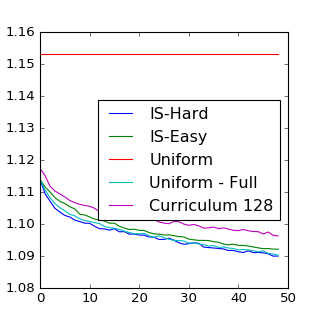

<IPython.core.display.Javascript object>


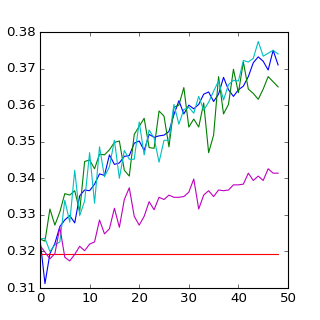

<IPython.core.display.Javascript object>


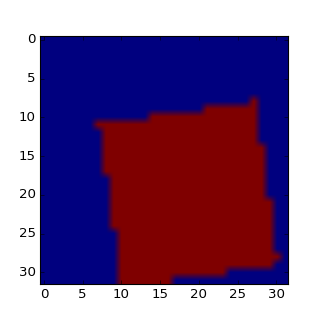

<IPython.core.display.Javascript object>


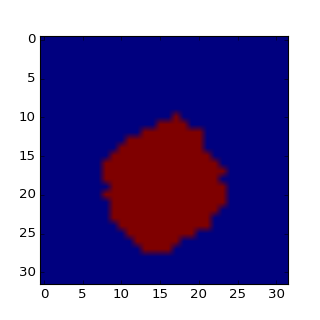

<IPython.core.display.Javascript object>


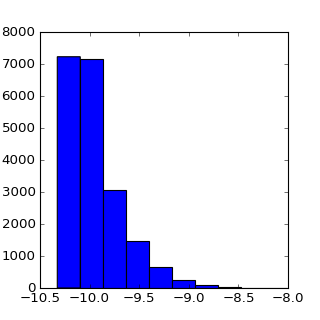

Epoch 1/1
400/400 [==============================] - 3s 7ms/step - loss: 1.1184 - categorical_accuracy: 0.3343
0
10.165041
Epoch 1/1
400/400 [==============================] - 2s 6ms/step - loss: 1.1195 - categorical_accuracy: 0.3205
Epoch 1/1
400/400 [==============================] - 2s 6ms/step - loss: 1.1068 - categorical_accuracy: 0.3322
Epoch 1/1
400/400 [==============================] - 2s 6ms/step - loss: 1.1122 - categorical_accuracy: 0.3284
1
10.008236
Epoch 1/1
400/400 [==============================] - 2s 6ms/step - loss: 1.1130 - categorical_accuracy: 0.3231
Epoch 1/1
400/400 [==============================] - 2s 6ms/step - loss: 1.1053 - categorical_accuracy: 0.3312
Epoch 1/1
400/400 [==============================] - 2s 6ms/step - loss: 1.1093 - categorical_accuracy: 0.3253
2
10.232033
Epoch 1/1
400/400 [==============================] - 2s 6ms/step - loss: 1.1094 - categorical_accuracy: 0.3269
Epoch 1/1
400/400 [==============================] - 2s 6ms/step - loss: 1.1

In [ ]:
NumEpochs=300
%matplotlib notebook
import keras as keras
from keras.models import Sequential
from keras.layers import LSTM, Dense,BatchNormalization,Dropout,Flatten, Conv1D, Conv2D, MaxPool2D
from keras.losses import binary_crossentropy, categorical_crossentropy
from keras.metrics import categorical_accuracy
from keras import regularizers,optimizers
from keras.regularizers import l2
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
import gzip
from keras.layers.core import Lambda
from scipy.integrate import trapz

from keras.layers.core import Lambda
from keras import backend as K    

def mini_batches(InputSample,BatchSize):
    Index = np.array(range(InputSample.shape[0]),dtype=int)
    NumBatches = np.int(InputSample.shape[0]/BatchSize)
    Removed = np.array([],dtype=int)

    BatchInd =[]
    for BatchLoop in range(NumBatches):
        RemainIndex = np.delete(Index,Removed)
        SampleInd = np.random.choice(RemainIndex,size=BatchSize,replace=False)
        Removed = np.append(Removed,SampleInd,axis=0)

        BatchInd.append(SampleInd)
    RemainIndex = np.delete(Index,Removed)
    BatchInd.append(RemainIndex)

    return BatchInd,NumBatches

def Get_Feats_and_Targets(filename):
    import numpy as np

    def line_to_Feats(line):
        line = line.split(' ')
        Feats = np.asarray(line[0:1024])
        Target = np.zeros([3])
        Target[int(line[1024])] = 1
        return Feats,Target

    f = open(filename, 'r')
    lines = f.readlines()
    Features = []
    Targets = []
    for i in range(len(lines)-1):
        line = lines[i+1]
        Feats,Tgts = line_to_Feats(line)
        Features.append(Feats)
        Targets.append(Tgts)

    return np.asarray(Features,dtype = 'float64'), np.asarray(Targets,dtype = 'int')

[TrainInputs_Easy,TrainTargets_Easy] = Get_Feats_and_Targets('shapeset1_1cspo_2_3.10000.train.amat')
#     [ValInputs_Easy,ValTargets_Easy] = Get_Feats_and_Targets('shapeset1_1cspo_2_3.5000.valid.amat')

[TrainInputs,TrainTargets] = Get_Feats_and_Targets('shapeset2_1cspo_2_3.10000.train.amat')
[ValInputs,ValTargets] = Get_Feats_and_Targets('shapeset2_1cspo_2_3.5000.valid.amat')

FullTrainInputs = np.append(TrainInputs,TrainInputs_Easy,axis=0)
FullTrainTargets = np.append(TrainTargets,TrainTargets_Easy,axis=0)

Conv = 0
if Conv == 1:
    TrainInputs_Easy = np.reshape(TrainInputs_Easy,[TrainInputs_Easy.shape[0],1,32,32]).transpose(0,2,3,1)
    TrainInputs = np.reshape(TrainInputs,[TrainInputs.shape[0],1,32,32]).transpose(0,2,3,1)
    ValInputs = np.reshape(ValInputs,[ValInputs.shape[0],1,32,32]).transpose(0,2,3,1)
    FullTrainInputs = np.reshape(FullTrainInputs,[FullTrainInputs.shape[0],1,32,32]).transpose(0,2,3,1)

print(FullTrainInputs.shape)

data_dim = TrainInputs.shape[1]
if Conv == 1:
    data_dim2 = TrainInputs.shape[2]
    NumChannels = 1
NumSamples = TrainInputs.shape[0]
NumSamplesFull = FullTrainInputs.shape[0]
NumSamplesEasy = TrainInputs_Easy.shape[0]
Num_Targets = TrainTargets.shape[-1]

index = np.linspace(0,NumSamples,NumSamples,endpoint=False,dtype=int)

reg_coeff = 0

def Gen_Conv_Model(reg_coeff):
    model = Sequential()
    model.add(Conv2D(100,(3,3),activation='relu',input_shape =(data_dim,data_dim2,NumChannels),data_format="channels_last"))
    model.add(MaxPool2D())
    model.add(BatchNormalization())
    model.add(Conv2D(100,(3,3),activation='relu',data_format="channels_last"))
    model.add(MaxPool2D())
    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dense(100,activation='relu',kernel_regularizer=l2(reg_coeff)))
    model.add(Dense(100,activation='relu',kernel_regularizer=l2(reg_coeff)))
    model.add(Dense(Num_Targets,activation = 'softmax',kernel_regularizer=l2(reg_coeff),input_shape =(data_dim,)))
    optim = optimizers.adam(lr=0.00001)
    model.compile(loss='categorical_crossentropy',optimizer=optim,metrics=['categorical_accuracy'])

    return model

def Gen_Model(reg_coeff):
    model = Sequential()
    model.add(Dense(300,activation='tanh',input_shape =(data_dim,),kernel_regularizer=l2(reg_coeff)))
    model.add(Dense(300,activation='tanh',input_shape =(data_dim,),kernel_regularizer=l2(reg_coeff)))
    model.add(Dense(300,activation='tanh',input_shape =(data_dim,),kernel_regularizer=l2(reg_coeff)))
    model.add(Dense(Num_Targets,activation = 'softmax',kernel_regularizer=l2(reg_coeff),input_shape =(data_dim,)))
    optim = optimizers.sgd(lr=0.0001)
    model.compile(loss='categorical_crossentropy',optimizer=optim,metrics=['categorical_accuracy'])

    return model

if Conv == 1:
    UniHard_model = Gen_Conv_Model(reg_coeff) 
    UniEasy_model = Gen_Conv_Model(reg_coeff)
    Cur_model = Gen_Conv_Model(reg_coeff)
    Uni_model = Gen_Conv_Model(reg_coeff)
    Uni_model_full = Gen_Conv_Model(reg_coeff)
else:
    UniHard_model = Gen_Model(reg_coeff) 
    UniEasy_model = Gen_Model(reg_coeff)
    Cur_model = Gen_Model(reg_coeff)
    Uni_model = Gen_Model(reg_coeff)
    Uni_model_full = Gen_Model(reg_coeff)

UniHard_model.set_weights(Uni_model.get_weights())
UniEasy_model.set_weights(Uni_model.get_weights())
Cur_model.set_weights(Uni_model.get_weights())
Uni_model_full.set_weights(Uni_model.get_weights())

def acquisition_function_BALD(model,samples,Num_Targets,temperature=1,Target_Ratio = 5):
    nb_MC_samples = 100
    MC_output = K.function([model.layers[0].input, K.learning_phase()], [model.layers[-1].output])
    MC_samples = np.zeros([nb_MC_samples,samples.shape[0],Num_Targets])
    learning_phase = True 
    for i in range(nb_MC_samples):
        MC_samples[i,:,:] = np.array([MC_output([samples, learning_phase])[0]])

    expected_entropy = - np.mean(np.sum(MC_samples * np.log(MC_samples + 1e-10), axis=-1), axis=0)  # [batch size]
    expected_p = np.mean(MC_samples, axis=0)
    entropy_expected_p = - np.sum(expected_p * np.log(expected_p + 1e-10), axis=-1)  # [batch size]
    BALD_acq = entropy_expected_p - expected_entropy

    Exp_BALD = np.exp(BALD_acq/temperature)
    Sampling_Prob = Exp_BALD/np.sum(Exp_BALD).astype(float)

    Max_Prob_Ratio = Sampling_Prob.max()/Sampling_Prob.min()
    Target_Ratio = Target_Ratio
    if Max_Prob_Ratio < Target_Ratio:
        while Max_Prob_Ratio <Target_Ratio:
            temperature = temperature*0.99
            Exp_BALD = np.exp(BALD_acq/temperature)
            StoreSampling_Prob = Sampling_Prob.copy()
            Sampling_Prob = Exp_BALD/np.sum(Exp_BALD).astype(float)
            Max_Prob_Ratio = Sampling_Prob.max()/Sampling_Prob.min()
            if np.isnan(Max_Prob_Ratio):
                Sampling_Prob = StoreSampling_Prob.copy()
    else:
        while Max_Prob_Ratio > Target_Ratio:
            temperature = temperature*1.01
            Exp_BALD = np.exp(BALD_acq/temperature)
            StoreSampling_Prob = Sampling_Prob.copy()
            Sampling_Prob = Exp_BALD/np.sum(Exp_BALD).astype(float)
            Max_Prob_Ratio = Sampling_Prob.max()/Sampling_Prob.min()
            if np.isnan(Max_Prob_Ratio):
                Sampling_Prob = StoreSampling_Prob.copy()
    return Sampling_Prob

def acquisition_function_dist_to_threshold(model,samples,Num_Targets,temperature=1,Target_Ratio=5):
    Output = model.predict(samples)
    Output -= 1/float(Num_Targets)
    Dist_to_Threshold = np.sum(np.abs(Output),1)
    Exp_Dist_to_Threshold = np.exp(Dist_to_Threshold/temperature)
    Sampling_Prob = Exp_Dist_to_Threshold/np.sum(Exp_Dist_to_Threshold).astype(float)
    Max_Prob_Ratio = Sampling_Prob.max()/Sampling_Prob.min()
    Target_Ratio = Target_Ratio
    if Max_Prob_Ratio < Target_Ratio:
        while Max_Prob_Ratio <Target_Ratio:
            temperature = temperature*0.99
            Exp_Dist_to_Threshold = np.exp(Dist_to_Threshold/temperature)
            Sampling_Prob = Exp_Dist_to_Threshold/np.sum(Exp_Dist_to_Threshold).astype(float)
            Max_Prob_Ratio = Sampling_Prob.max()/Sampling_Prob.min()
    else:
        while Max_Prob_Ratio > Target_Ratio:
            temperature = temperature*1.01
            Exp_Dist_to_Threshold = np.exp(Dist_to_Threshold/temperature)
            Sampling_Prob = Exp_Dist_to_Threshold/np.sum(Exp_Dist_to_Threshold).astype(float)
            Max_Prob_Ratio = Sampling_Prob.max()/Sampling_Prob.min()
    return Sampling_Prob

count = 0 
Num_Epochs = NumEpochs
Num_BurnIn = 1
Switch_Epoch = 128
Batch_Size = 50

NumTasks = 0
try:
    SwitchPoint = np.int(Num_Epochs/NumTasks)
except:
    SwitchPoint = 1
Smoothing_Constant = 0

Val_Error = np.zeros([Num_Epochs,5])
Val_Acc = np.zeros([Num_Epochs,5])

def Biased_Batch(Inputs,Targets,Batch_Size,Sampling_Probability,Weighting_Flag = 1,NumTasks = 0,CurrentTask=0):
    while True:
        index = np.linspace(0,Inputs.shape[0],Inputs.shape[0],endpoint=False,dtype=int)
        if NumTasks > 1:
            Cutoff = np.percentile(Sampling_Probability,np.max(100-(CurrentTask*(1/np.float(NumTasks))*100),0))
#             LowerCutoff = np.percentile(Sampling_Probability,np.max(100-(CurrentTask*(1/np.float(NumTasks))*100),0))
#             UpperCutoff = np.percentile(Sampling_Probability,np.max(100-((CurrentTask-1)*(1/np.float(NumTasks))*100),0))
#             TaskInd = Sampling_Probability >= LowerCutoff
#             TaskInd[Sampling_Probability > UpperCutoff]= False
#             Sampling_Probability[:] = 0
#             Sampling_Probability[TaskInd] = 1
#             Sampling_Probability = Sampling_Probability/np.sum(Sampling_Probability,dtype=float)
            TaskInd = Sampling_Probability >= Cutoff
            DropInd = Sampling_Probability <  Cutoff
#             Sampling_Probability[TaskInd] = 1
            Sampling_Probability[DropInd] = 0
            Sampling_Probability = Sampling_Probability/np.sum(Sampling_Probability,dtype=float)

        Batch = np.random.choice(index,size=Batch_Size,replace=False,p=Sampling_Probability)
        Batch_Inputs = Inputs[Batch,:]
        Batch_Targets = Targets[Batch,:]
        if Weighting_Flag == 1:
            FullWeights = Sampling_Probability**-1
            FullWeights = FullWeights/np.mean(FullWeights)
        elif Weighting_Flag == -1:
            FullWeights = Sampling_Probability/np.mean(Sampling_Probability)
        else:
            FullWeights = np.ones(Inputs.shape[0])
        Weights = FullWeights[Batch]
        yield (Batch_Inputs,Batch_Targets,Weights)

fig = plt.figure(figsize = [4,4])
ax = fig.add_subplot(111)
plt.ion()
fig.show()
fig.canvas.draw()

fig2 = plt.figure(figsize = [4,4])
ax2 = fig2.add_subplot(111)
plt.ion()
fig2.show()
fig2.canvas.draw()

fig3 = plt.figure(figsize = [4,4])
ax3 = fig3.add_subplot(111)
plt.ion()
fig3.show()
fig3.canvas.draw()

fig4 = plt.figure(figsize = [4,4])
ax4 = fig4.add_subplot(111)
plt.ion()
fig4.show()
fig4.canvas.draw()

fig5 = plt.figure(figsize = [4,4])
ax5 = fig5.add_subplot(111)
plt.ion()
fig5.show()
fig5.canvas.draw()


for EpochLoop in  range(Num_Epochs):
    if count < Num_BurnIn:

#             Uni_model.fit_generator(Biased_Batch(TrainInputs,TrainTargets,Batch_Size,1/np.float(NumSamples)*np.ones(NumSamples)),
#                                 steps_per_epoch=np.int(NumSamples/Batch_Size),verbose=0)

        Uni_model_full.fit_generator(Biased_Batch(FullTrainInputs,FullTrainTargets,Batch_Size,1/np.float(NumSamplesFull)*np.ones(NumSamplesFull)),
                            steps_per_epoch=np.int(NumSamplesFull/Batch_Size),verbose=1)

        if count < Switch_Epoch:
            Cur_model.fit_generator(Biased_Batch(TrainInputs_Easy,TrainTargets_Easy,Batch_Size,1/np.float(NumSamplesEasy)*np.ones(NumSamplesEasy)),
                            steps_per_epoch=np.int(NumSamplesEasy/Batch_Size),verbose=0)
        else:
            Cur_model.fit_generator(Biased_Batch(FullTrainInputs,FullTrainTargets,Batch_Size,1/np.float(NumSamplesFull)*np.ones(NumSamplesFull)),
                            steps_per_epoch=np.int(NumSamplesFull/Batch_Size),verbose=0)

        UniHard_model.set_weights(Uni_model_full.get_weights())
        UniEasy_model.set_weights(Uni_model_full.get_weights())

        Error = UniHard_model.test_on_batch(ValInputs,ValTargets)
        Val_Error[count,0] = Error[0]
        Val_Acc[count,0] = Error[1]

        Error = UniEasy_model.test_on_batch(ValInputs,ValTargets)
        Val_Error[count,1] = Error[0]
        Val_Acc[count,1] = Error[1]

        Error = Uni_model.test_on_batch(ValInputs,ValTargets)
        Val_Error[count,2] = Error[0]
        Val_Acc[count,2] = Error[1]

        Error = Cur_model.test_on_batch(ValInputs,ValTargets)
        Val_Error[count,3] = Error[0]
        Val_Acc[count,3] = Error[1]

        Error = Uni_model_full.test_on_batch(ValInputs,ValTargets)
        Val_Error[count,4] = Error[0]
        Val_Acc[count,4] = Error[1]


    else:

        UniHard_Sampling_Probability = acquisition_function_dist_to_threshold(UniHard_model,FullTrainInputs,Num_Targets,1,10)
        UniEasy_Sampling_Probability = 1/acquisition_function_dist_to_threshold(UniEasy_model,FullTrainInputs,Num_Targets,1,10)
        UniEasy_Sampling_Probability /= UniEasy_Sampling_Probability.sum().astype(float)

        MaxProbInd = UniHard_Sampling_Probability.argmax()
        MinProbInd = UniHard_Sampling_Probability.argmin()

        if Conv == 1:
            ax3.clear()
            ax3.imshow(FullTrainInputs[MaxProbInd,:,:,:].reshape([32,32]))
            fig3.canvas.draw()
            ax4.clear()
            ax4.imshow(FullTrainInputs[MinProbInd,:,:].reshape([32,32]))
            fig4.canvas.draw()
        else:
            ax3.clear()
            ax3.imshow(FullTrainInputs[MaxProbInd,:].reshape([32,32]))
            fig3.canvas.draw()
            ax4.clear()
            ax4.imshow(FullTrainInputs[MinProbInd,:].reshape([32,32]))
            fig4.canvas.draw()
            
        ax5.clear()
        ax5.hist(np.log(UniHard_Sampling_Probability))
        fig5.canvas.draw()

#             ax3.clear()
#             ax3.imshow(np.transpose(np.reshape(FullTrainInputs[MaxProbInd,:],[32,32])))
#             fig3.canvas.draw()

#             ax4.clear()
#             ax4.imshow(np.transpose(np.reshape(FullTrainInputs[MinProbInd,:],[32,32])))
#             fig4.canvas.draw()


        print(UniEasy_Sampling_Probability.max()/UniEasy_Sampling_Probability.min())

        UniHard_model.fit_generator(Biased_Batch(FullTrainInputs,FullTrainTargets,Batch_Size,UniHard_Sampling_Probability,0,NumTasks,np.int(count/SwitchPoint)+1),
                                 steps_per_epoch=np.int(NumSamplesFull/Batch_Size),verbose=1)

        UniEasy_model.fit_generator(Biased_Batch(FullTrainInputs,FullTrainTargets,Batch_Size,UniEasy_Sampling_Probability,0,NumTasks,np.int(count/SwitchPoint)+1),
                                 steps_per_epoch=np.int(NumSamplesFull/Batch_Size),verbose=1)

#             Uni_model.fit_generator(Biased_Batch(TrainInputs,TrainTargets,Batch_Size,1/(NumSamples*np.ones(NumSamples))),
#                                     steps_per_epoch=np.int(NumSamples/Batch_Size),verbose=0)

        Uni_model_full.fit_generator(Biased_Batch(FullTrainInputs,FullTrainTargets,Batch_Size,1/(NumSamplesFull*np.ones(NumSamplesFull))),
                                steps_per_epoch=np.int(NumSamplesFull/Batch_Size),verbose=1)

        if count < Switch_Epoch:
            Cur_model.fit_generator(Biased_Batch(TrainInputs_Easy,TrainTargets_Easy,Batch_Size,1/np.float(NumSamplesEasy)*np.ones(NumSamplesEasy)),
                            steps_per_epoch=np.int(NumSamplesEasy/Batch_Size),verbose=0)
        else:
            Cur_model.fit_generator(Biased_Batch(FullTrainInputs,FullTrainTargets,Batch_Size,1/np.float(NumSamplesFull)*np.ones(NumSamplesFull)),
                            steps_per_epoch=np.int(NumSamplesFull/Batch_Size),verbose=0)

        Error = UniHard_model.test_on_batch(ValInputs,ValTargets)
        Val_Error[count,0] = Error[0]
        Val_Acc[count,0] = Error[1]

        Error = UniEasy_model.test_on_batch(ValInputs,ValTargets)
        Val_Error[count,1] = Error[0]
        Val_Acc[count,1] = Error[1]

        Error = Uni_model.test_on_batch(ValInputs,ValTargets)
        Val_Error[count,2] = Error[0]
        Val_Acc[count,2] = Error[1]

        Error = Cur_model.test_on_batch(ValInputs,ValTargets)
        Val_Error[count,3] = Error[0]
        Val_Acc[count,3] = Error[1]

        Error = Uni_model_full.test_on_batch(ValInputs,ValTargets)
        Val_Error[count,4] = Error[0]
        Val_Acc[count,4] = Error[1]

    print(count)

    count += 1
    ax.clear()
    ax.plot(Val_Error[0:count,0],label='IS-Hard')
    ax.plot(Val_Error[0:count,1],label='IS-Easy')
    ax.plot(Val_Error[0:count,2],label='Uniform')
    ax.plot(Val_Error[0:count,4],label='Uniform - Full')
    ax.plot(Val_Error[0:count,3],label='Curriculum 128')
    ax.legend(loc='best')
    fig.canvas.draw()

    ax2.clear()
    ax2.plot(Val_Acc[0:count,0],label='IS-Hard')
    ax2.plot(Val_Acc[0:count,1],label='IS-Easy')
    ax2.plot(Val_Acc[0:count,2],label='Uniform')
    ax2.plot(Val_Acc[0:count,4],label='Uniform - Full')
    ax2.plot(Val_Acc[0:count,3],label='Curriculum 128')
    fig2.canvas.draw()





In [4]:
ax5.hist

<bound method AxesSubplot.hist of <matplotlib.axes._subplots.AxesSubplot object at 0x13700a190>>

In [ ]:
[TestInputs,TestTargets] = Get_Feats_and_Targets('shapeset2_1cspo_2_3.5000.test.amat')
    
if Conv == 1:
    TestInputs = np.reshape(TestInputs,[TestInputs.shape[0],1,32,32]).transpose(0,2,3,1)

TestError = np.zeros([5,2])
TestError[0,:] = UniHard_model.test_on_batch(TestInputs,TestTargets)
TestError[1,:] = UniEasy_model.test_on_batch(TestInputs,TestTargets)
TestError[2,:] = Uni_model.test_on_batch(TestInputs,TestTargets)
TestError[3,:] = Cur_model.test_on_batch(TestInputs,TestTargets)
TestError[4,:] = Uni_model_full.test_on_batch(TestInputs,TestTargets)